#1. Load data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/My Drive/raai_school_2024.csv", delimiter = ';')

In [4]:
data.head()

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr
0,2,23170,2023-01-01,2073.48,2046.36,0.00,5.33,6.91416,199.50
1,2,23170,2023-03-01,1525.44,2484.21,2404.08,5.19,4.22532,186.00
2,2,23170,2023-04-01,1762.49,2337.36,1672.29,5.00,4.82284,227.50
3,2,23170,2023-05-01,1868.41,0.00,4099.85,5.08,5.13227,242.03
4,2,23170,2023-07-01,2682.54,1933.29,0.00,8.64,6.91416,362.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206079 entries, 0 to 3206078
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   house_tkn       int64  
 1   flat_tkn        int64  
 2   payment_period  object 
 3   income          float64
 4   debt            float64
 5   raised          float64
 6   volume_cold     float64
 7   volume_hot      float64
 8   volume_electr   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 220.1+ MB


In [6]:
data.isnull().sum()

house_tkn               0
flat_tkn                0
payment_period          0
income                  0
debt                    0
raised                  0
volume_cold        220369
volume_hot        1773296
volume_electr     1214775
dtype: int64

In [7]:
data.describe()

,house_tkn,flat_tkn,income,debt,raised,volume_cold,volume_hot,volume_electr
count,3.206079e+06,3.206079e+06,3.206079e+06,3.206079e+06,3.206079e+06,2.985710e+06,1.432783e+06,1.991304e+06
mean,9.094747e+04,3.051403e+05,8.775732e+02,1.578240e+03,7.888475e+02,7.506323e+00,3.474291e+00,1.640206e+02
std,5.287637e+04,1.780600e+05,1.051897e+03,1.021570e+04,1.261571e+03,1.645744e+01,5.174198e+00,7.631953e+02
min,2.000000e+00,1.000000e+00,-1.681290e+05,-2.413084e+05,-6.333156e+04,-2.679330e+00,0.000000e+00,-2.275800e+04
25%,4.463500e+04,1.504640e+05,2.952600e+02,-9.855000e+01,1.154800e+02,3.000000e+00,1.067000e+00,7.000000e+01
50%,9.012200e+04,3.087160e+05,6.659400e+02,0.000000e+00,5.256100e+02,5.000000e+00,2.655000e+00,1.230000e+02
75%,1.370630e+05,4.590460e+05,1.175080e+03,3.928000e+02,1.065160e+03,9.000000e+00,4.268000e+00,2.000000e+02
max,1.845430e+05,6.172180e+05,3.368486e+05,3.123213e+06,1.585733e+05,3.374000e+03,4.255268e+03,1.000000e+06


#2. Predict residents

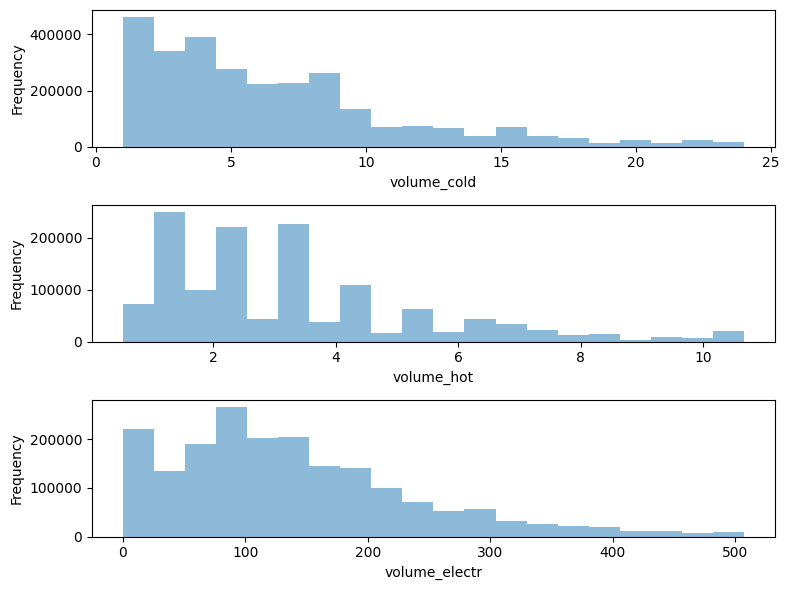

In [8]:
features = ['volume_cold', 'volume_hot', 'volume_electr']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

for i, feature in enumerate(features):
    lower_bound = np.percentile(data[feature].dropna(), 5)
    upper_bound = np.percentile(data[feature].dropna(), 97)
    filtered_data = data[feature][(data[feature] >= lower_bound) & (data[feature] <= upper_bound)].dropna()
    filtered_data.dropna()
    axes[i].hist(filtered_data, bins=20, alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
data[data['volume_electr'] <0].shape[0]

1655

In [10]:
data[data['volume_cold'] <0]

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr
3108383,178444,47234,2023-03-01,632.8,-1530.93,0.00,-1.31967,NaN,140.0
3108392,178444,108786,2023-03-01,452.0,452.00,953.17,-2.67933,NaN,100.0


Конвертировать отрицательные значения в Nan

In [11]:
data['volume_cold'] = data['volume_cold'].apply(lambda x: np.nan if x < 0 else x)
data['volume_electr'] = data['volume_electr'].apply(lambda x: np.nan if x < 0 else x)

Сгруппировать данные для каждой квартиры, используя медианное значение, чтобы избежать нечетных значений.

In [12]:
grouped = data.groupby('flat_tkn').agg({
    'volume_cold': lambda x: np.median(x.dropna()) if x.notna().any() else np.nan,
    'volume_hot': lambda x: np.median(x.dropna()) if x.notna().any() else np.nan,
    'volume_electr': lambda x: np.median(x.dropna()) if x.notna().any() else np.nan
}).reset_index()

In [13]:
grouped.shape

(420635, 4)

Для 1 человек: Объём потребления ХВС = 3.0, Объём потребления ГВС = 2.0,	Объём потребления Электроэнергии 100

In [27]:
grouped['ratio_cold'] = (1.1 * grouped['volume_cold'] / 3.0).round()
grouped['ratio_hot'] = (1.1 * grouped['volume_hot'] / 2.0).round()
grouped['ratio_electr'] = (1.1 * grouped['volume_electr'] / 100.0).round()

In [28]:
grouped.loc[(grouped['ratio_cold'] == 0) & (grouped['volume_cold'] > 0.0), 'ratio_cold'] = 1
grouped.loc[(grouped['ratio_hot'] == 0) & (grouped['volume_hot'] > 0.0), 'ratio_hot'] = 1
grouped.loc[(grouped['ratio_electr'] == 0) & (grouped['volume_electr'] > 0.0), 'ratio_electr'] = 1

In [29]:
grouped.loc[(grouped['ratio_electr'] == 0.0) & (grouped['volume_electr'] == 0.0), 'ratio_electr'] = np.nan

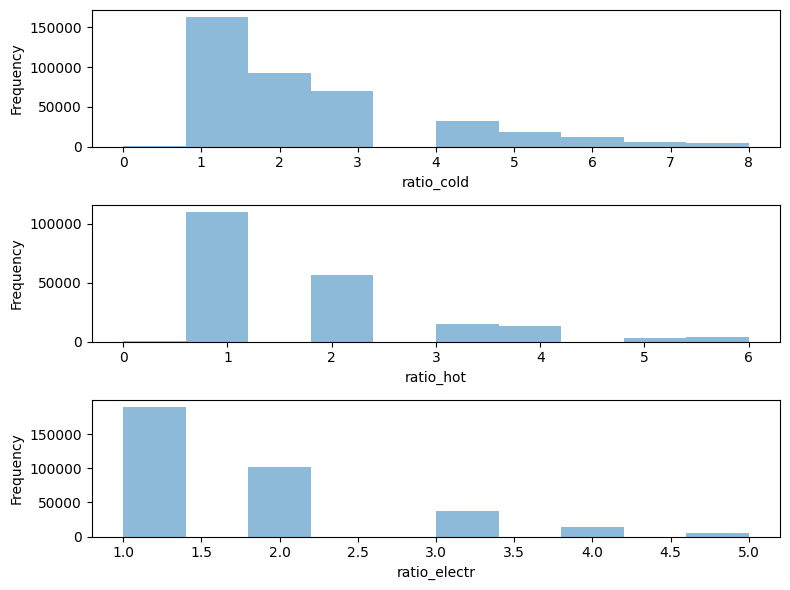

In [30]:
features = ['ratio_cold', 'ratio_hot', 'ratio_electr']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

for i, feature in enumerate(features):
    lower_bound = np.percentile(grouped[feature].dropna(), 0)
    upper_bound = np.percentile(grouped[feature].dropna(), 97)
    filtered_data = grouped[feature][(grouped[feature] >= lower_bound) & (grouped[feature] <= upper_bound)].dropna()
    axes[i].hist(filtered_data, bins=10, alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [31]:
grouped.head()

,flat_tkn,volume_cold,volume_hot,volume_electr,ratio_cold,ratio_hot,ratio_electr,residents_avg_count
0,1,4.86,NaN,0.0,2.0,NaN,NaN,1
1,2,8.25,NaN,100.0,3.0,NaN,1.0,2
2,3,3.00,NaN,42.0,1.0,NaN,1.0,1
3,4,5.00,NaN,109.0,2.0,NaN,1.0,1
4,13,3.00,1.0,175.0,1.0,1.0,2.0,1


In [32]:
def predict_people(row):
    if pd.isnull(row['ratio_cold']) and pd.isnull(row['ratio_hot']) and pd.isnull(row['ratio_electr']):
        return 0
    else:
        non_nan_values = row[['ratio_cold', 'ratio_hot', 'ratio_electr']].dropna()
        median_value = np.median(non_nan_values)
        if median_value > 10:
            return np.min(non_nan_values)
        else:
            return median_value

In [33]:
grouped['residents_avg_count'] = grouped.apply(predict_people, axis=1)

In [34]:
grouped['residents_avg_count'] = grouped['residents_avg_count'].apply(np.ceil).astype(int)

#3. Output

In [35]:
output_df = pd.DataFrame({
    'flat_tkn': grouped['flat_tkn'],
    'residents_avg_count': grouped['residents_avg_count'].round().astype(int)
})

In [36]:
output_df.to_csv('result_raai_school_2024.csv', sep=';', index=False)

In [37]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420635 entries, 0 to 420634
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   flat_tkn             420635 non-null  int64
 1   residents_avg_count  420635 non-null  int64
dtypes: int64(2)
memory usage: 6.4 MB


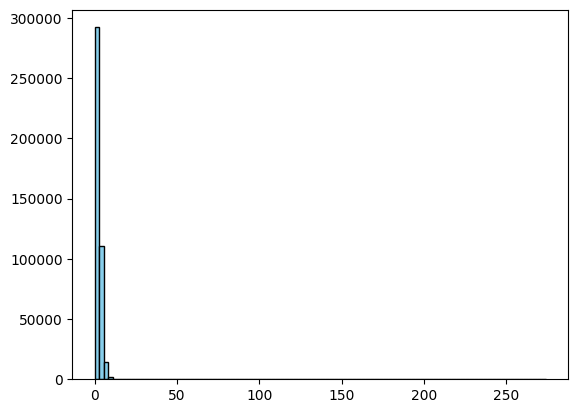

In [39]:
plt.hist(output_df['residents_avg_count'], bins=100, color='skyblue', edgecolor='black')
plt.show()

In [40]:
output_df.head()

,flat_tkn,residents_avg_count
0,1,2
1,2,2
2,3,1
3,4,2
4,13,1


In [41]:
output_df.describe()

,flat_tkn,residents_avg_count
count,420635.000000,420635.000000
mean,305446.813308,2.247987
std,178107.937235,1.811379
min,1.000000,0.000000
25%,150807.500000,1.000000
50%,308679.000000,2.000000
75%,459423.500000,3.000000
max,617218.000000,274.000000


In [42]:
output_df.loc[output_df['residents_avg_count'].idxmax()]

flat_tkn               403641
residents_avg_count       274
Name: 277904, dtype: int64

In [43]:
data[data['flat_tkn'] == 403641]

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr
740305,40944,403641,2023-03-01,0.00,-673.05,0.0,NaN,NaN,0.0
740306,40944,403641,2023-04-01,0.00,-673.05,0.0,NaN,NaN,0.0
740307,40944,403641,2023-05-01,0.00,-673.05,0.0,NaN,NaN,0.0
740308,40944,403641,2023-06-01,0.00,-673.05,0.0,NaN,NaN,NaN
740309,40944,403641,2023-07-01,0.00,-673.05,0.0,NaN,NaN,NaN
740310,40944,403641,2023-11-01,22363.68,-343.52,0.0,748.44,NaN,10.0
740311,40944,403641,2024-01-01,0.00,22318.48,0.0,NaN,NaN,NaN


In [44]:
grouped[grouped['flat_tkn'] == 403641]

,flat_tkn,volume_cold,volume_hot,volume_electr,ratio_cold,ratio_hot,ratio_electr,residents_avg_count
277904,403641,748.44,NaN,0.0,274.0,NaN,NaN,274
